In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Data:
    def __init__(self, x_dim):
        self.xa, self.xb, self.x_grid_size = x_dim
        self.nx = self.x_grid_size + 1
        self.dx = (self.xb - self.xa) / self.x_grid_size
        self.x = np.linspace(self.xa, self.xb, self.nx)
        
    def get_x(self):
        return self.x


class NumericalSolver(Data):
    def __init__(self, x_dim, cfl):
        super().__init__(x_dim)
        self.cfl = cfl
        self.n_iters = 0
    
    def initial_solution(self):
        return 1/(2*np.pi) * np.sin(2*np.pi*self.x)
    
    def boundary_condition(self, u):
        u[0] = 0
        u[-1] = 0
        return u
        
    def timestep(self, u):
        sn_max = np.max(np.abs(u))
        return self.cfl * self.dx / sn_max
    
    def calculate_r(self, u, v):
        r = np.zeros(self.nx)
        for i in range(1, self.nx-1):
            r[i] = -v[i]*(u[i] - u[i-1])/self.dx if u[i] > 0 else -v[i]*(u[i+1] - u[i])/self.dx
        return r
        
    def rk4_method(self, u, dt):
        rn = self.calculate_r(u, u)
        # step 1
        u_1 = u + 0.5*dt*rn
        r1 = self.calculate_r(u_1, u)
        # step 2
        u_2 = u + 0.5*dt*r1
        r2 = self.calculate_r(u_2, u)
        # step 3
        u_3 = u + dt*r2
        r3 = self.calculate_r(u_3, u)
        # step 4
        u_new = u + (rn + 2.0*r1 + 2.0*r2 + r3)*dt/6
        return u_new
    
    def solve(self, tf):
        u_old = self.initial_solution()
        t = 0
        
        while t <= tf:
            self.n_iters += 1
            dt = self.timestep(u_old)
            t += dt

            u_new = self.rk4_method(u_old, dt)
            u_new = self.boundary_condition(u_new)
            u_old = np.copy(u_new)
        
        return u_new
    
    
class ExactSolver(Data):
    def __init__(self, x_dim):
        super().__init__(x_dim)
        
    def solve(self, t):
        u_old = 1/(2*np.pi) * np.sin(2*np.pi*self.x)
        eps = 1e-5
        condition = 2 * eps
        while condition > eps:
            u_new = 1/(2*np.pi) * np.sin(2*np.pi*(self.x - u_old*t))
            condition = np.max(np.abs(u_new - u_old))
            
            u_old = np.copy(u_new)
        return u_new
    
    
def compare_and_save(x, u_exact, u_appr, tf, file_name):
    plt.plot(x, u_exact, color='green', linestyle='dashed', label='exact solution')
    plt.plot(x, u_appr, color='red', linestyle='dotted', label='RK4 method')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title(f'Solution at t = {tf}')
    plt.savefig(file_name)
    np.savez(file_name, u_exact=u_exact, u_appr=u_appr)

In [3]:
xa, xb, x_grid_size = (0, 1, 600)
x_dim = (xa, xb, x_grid_size)
cfl = 0.25

In [4]:
data = Data(x_dim)
x = data.get_x()
np.save('array', x)

In [5]:
numerical_solver = NumericalSolver(x_dim, cfl)
exact_solver = ExactSolver(x_dim)

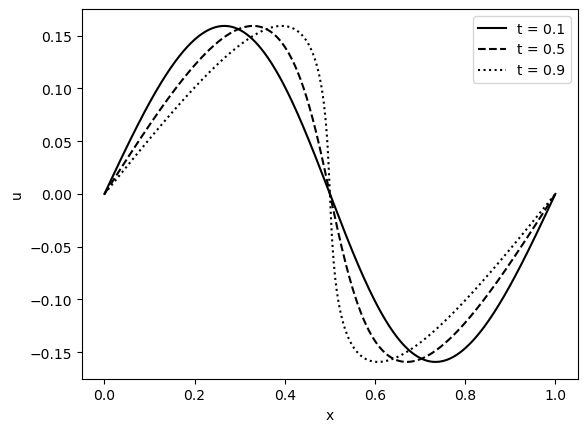

In [6]:
t = [0.1, 0.5, 0.9]
line = ['solid', 'dashed', 'dotted']
ut = []
for i in range(len(t)):
    u = exact_solver.solve(t[i])
    plt.plot(x, u, label=f't = {t[i]}', linestyle=line[i], color='black')
    ut.append(u)
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.savefig('exact_solution_at_01_05_09')
np.save('exact_solution_at_01_05_09', np.array(ut))

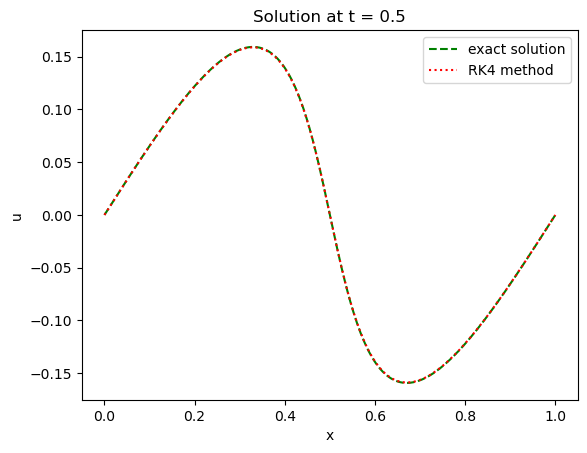

In [7]:
tf = 0.5
file_name = 'u_at_05'
u_05_appr = numerical_solver.solve(tf)
u_05_exact = exact_solver.solve(tf)
compare_and_save(x, u_05_exact, u_05_appr, tf, file_name)

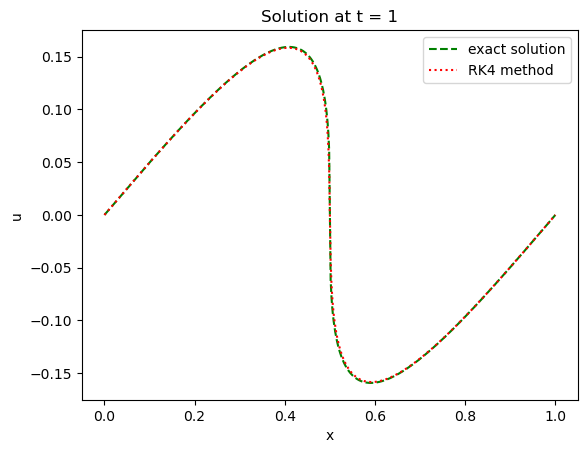

In [8]:
tf = 1
file_name = 'u_at_1'
u_1_appr = numerical_solver.solve(tf)
u_1_exact = exact_solver.solve(tf)
compare_and_save(x, u_1_exact, u_1_appr, tf, file_name)